In [1]:
import matplotlib

%matplotlib notebook
import glob
import pandas as pd
import mne
import matplotlib.pyplot as plt
from io import StringIO
import mne
from mne.io import read_raw_eeglab, read_epochs_eeglab
import numpy as np
from scipy import signal
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm_notebook
from sklearn.svm import SVR

import autosklearn.regression
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics
import multiprocessing
from tpot import TPOTRegressor
from oct2py import octave

from joblib import Parallel, delayed
import multiprocessing
from joblib import wrap_non_picklable_objects
import json
import pickle
import os.path
from mpl_toolkits.mplot3d import axes3d
from mayavi import mlab

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/pyparsing.py:2927: FutureWarning: Possible set intersection at position 3
  self.re = re.compile( self.reString )
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
features_filename = '36-features.xlsx'

In [3]:
df = pd.read_excel(features_filename, index_col=0)

# Histogram

In [4]:
df.head()

,all_all_max_amplitude,all_all_max_power,all_all_max_power_freq,all_alpha_max_amplitude,all_alpha_max_power,all_alpha_max_power_freq,all_beta_max_power,all_beta_max_power_freq,all_delta_max_power,all_delta_max_power_freq,...,wavelet_central_max_power_freq,wavelet_central_max_power_time,wavelet_ltm1_max_power_at_freq,wavelet_ltm1_max_power_at_time,wavelet_ltm1_max_power_freq,wavelet_ltm1_max_power_time,wavelet_rtm1_max_power_at_freq,wavelet_rtm1_max_power_at_time,wavelet_rtm1_max_power_freq,wavelet_rtm1_max_power_time
0,0.000002,2.777808e-16,36,0.000002,1.656928e-16,10,6.341239e-17,26,5.535620e-17,4,...,2350.831128,585.554590,0.976562,-0.202223,2583.616304,542.815473,0.976562,-0.426461,920.688314,207.925493
1,0.000002,7.045166e-16,10,0.000002,7.045166e-16,10,3.202701e-16,22,1.251420e-16,2,...,6924.342915,896.859848,11.048543,-0.075204,2749.205329,798.076467,15.625000,-0.341456,874.440057,272.307889
2,0.000002,4.643096e-16,24,0.000002,1.054613e-16,10,4.643096e-16,24,3.785974e-16,4,...,2708.489934,554.011272,0.976562,-0.179262,5350.733260,1593.658421,17.039183,-0.176331,822.499312,322.062396
3,0.000002,6.469294e-16,18,0.000002,6.144056e-16,10,6.469294e-16,18,3.054810e-16,2,...,1821.540388,374.120118,18.581361,-0.136271,1147.498869,474.570473,1.953125,-0.118195,846.045450,376.743475
4,0.000002,8.671570e-16,34,0.000002,3.254531e-16,8,7.122134e-16,26,2.245107e-16,2,...,7217.637690,1127.958657,7.812500,-0.102074,1469.422729,654.355452,1.161335,-0.208574,2639.615189,801.594979


In [151]:
df2 = df
bins = [0, 4, 8, 12, 20, 30, 46, 70]

# ax = plt.axes(projection='3d')
# ax.scatter3D(df['wavelet_ltm1_max_power_at_time'], df['mep_category_percentile'], df['mep_size'], c=df['mep_size'])
# ax.set_xlabel('Time - Ltm1')
# ax.set_ylabel('Scale - Ltm1')
# ax.set_zlabel('MEP size');

In [152]:
def categorize_by_freq_time(df2, bins = [0, 4, 8, 12, 20, 30, 46, 70], time_bins=np.linspace(-500, 0, 11)):
    df2['wavelet_all_max_power_at_freq_bin'] = pd.cut(df2['wavelet_all_max_power_at_freq'], bins)
    df2['wavelet_all_max_power_at_time_bin'] = pd.cut(df2['wavelet_all_max_power_at_time'], time_bins/1000)
    
    df2['wavelet_ltm1_max_power_at_freq_bin'] = pd.cut(df2['wavelet_ltm1_max_power_at_freq'], bins)
    df2['wavelet_ltm1_max_power_at_time_bin'] = pd.cut(df2['wavelet_ltm1_max_power_at_time'], time_bins/1000)
    
    df2['wavelet_rtm1_max_power_at_freq_bin'] = pd.cut(df2['wavelet_rtm1_max_power_at_freq'], bins)
    df2['wavelet_rtm1_max_power_at_time_bin'] = pd.cut(df2['wavelet_rtm1_max_power_at_time'], time_bins/1000)
    return df2

def groupby_freq_time(df):
    df = pd.DataFrame(df.to_records())
    df['wavelet_ltm1_max_power_at_freq_bin_left'] = df['wavelet_ltm1_max_power_at_freq_bin'].apply(lambda x: x.left)
    df['wavelet_ltm1_max_power_at_time_bin_left'] = df['wavelet_ltm1_max_power_at_time_bin'].apply(lambda x: x.left)
    df = df.fillna(0)
    return df

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

<IPython.core.display.Javascript object>


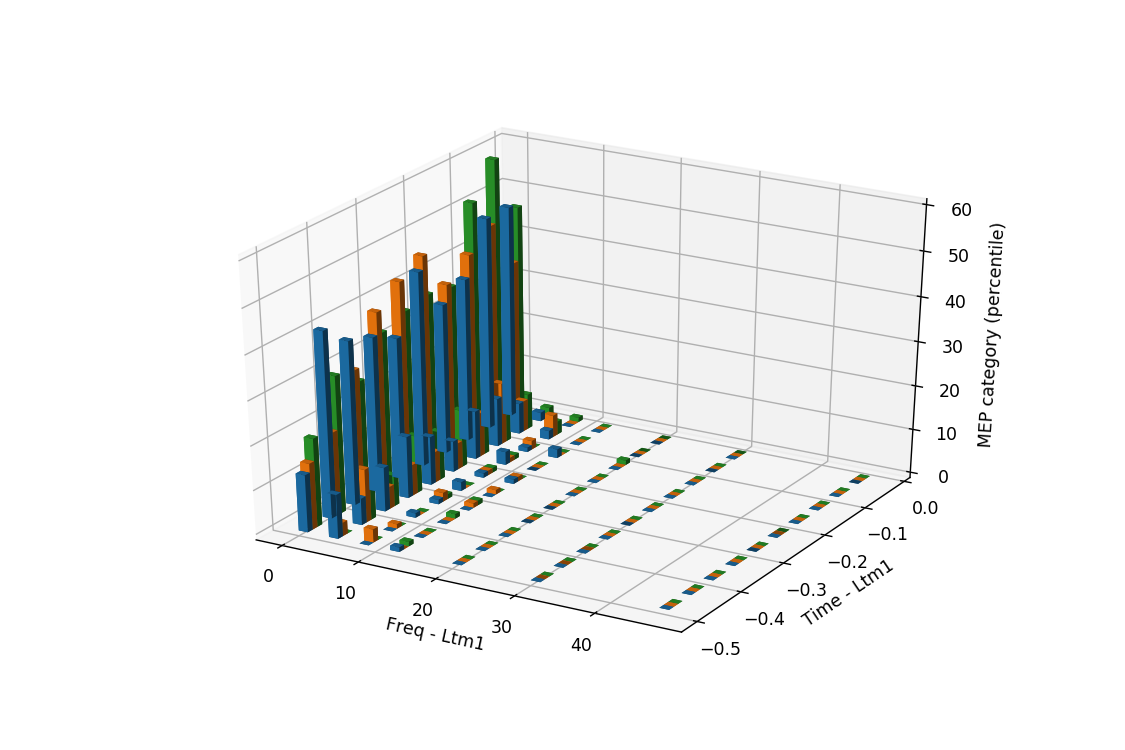

In [153]:
df_percentile_small = categorize_by_freq_time(df2[df2['mep_category_percentile'] == 0]).groupby(['wavelet_ltm1_max_power_at_freq_bin', 'wavelet_ltm1_max_power_at_time_bin']).count()
df_percentile_small = groupby_freq_time(df_percentile_small)

df_percentile_medium = categorize_by_freq_time(df2[df2['mep_category_percentile'] == 1]).groupby(['wavelet_ltm1_max_power_at_freq_bin', 'wavelet_ltm1_max_power_at_time_bin']).count()
df_percentile_medium = groupby_freq_time(df_percentile_medium)

df_percentile_large = categorize_by_freq_time(df2[df2['mep_category_percentile'] == 2]).groupby(['wavelet_ltm1_max_power_at_freq_bin', 'wavelet_ltm1_max_power_at_time_bin']).count()
df_percentile_large = groupby_freq_time(df_percentile_large)


time_width = 0.01
freq_width = 1.2
fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection='3d')
ax.bar3d(df_percentile_small['wavelet_ltm1_max_power_at_freq_bin_left'], df_percentile_small['wavelet_ltm1_max_power_at_time_bin_left'], np.zeros_like(df_percentile_small['ltm1_all_max_amplitude']), freq_width, time_width, df_percentile_small['ltm1_all_max_amplitude'], shade=True, zorder=0.5)
ax.bar3d(df_percentile_medium['wavelet_ltm1_max_power_at_freq_bin_left'], df_percentile_medium['wavelet_ltm1_max_power_at_time_bin_left'] + time_width, np.zeros_like(df_percentile_medium['ltm1_all_max_amplitude']), freq_width, time_width, df_percentile_medium['ltm1_all_max_amplitude'], shade=True, zorder=0.4)
ax.bar3d(df_percentile_large['wavelet_ltm1_max_power_at_freq_bin_left'], df_percentile_large['wavelet_ltm1_max_power_at_time_bin_left'] + time_width * 2, np.zeros_like(df_percentile_large['ltm1_all_max_amplitude']), freq_width, time_width, df_percentile_large['ltm1_all_max_amplitude'], shade=True, zorder=0.3)
ax.set_xlabel('Freq - Ltm1')
ax.set_ylabel('Time - Ltm1')
ax.set_zlabel('MEP category (percentile)');

In [138]:
df_percentile_small['wavelet_ltm1_max_power_at_freq_bin'].unique()

array([Interval(0, 4, closed='right'), Interval(4, 8, closed='right'),
       Interval(8, 12, closed='right'), Interval(12, 20, closed='right'),
       Interval(20, 30, closed='right'), Interval(30, 46, closed='right'),
       Interval(46, 70, closed='right')], dtype=object)

<IPython.core.display.Javascript object>


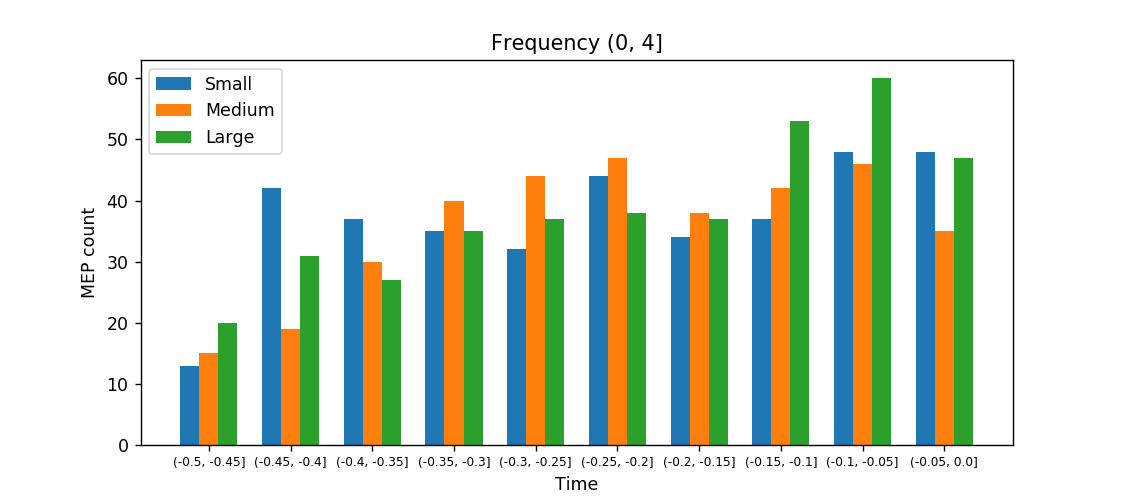

<IPython.core.display.Javascript object>


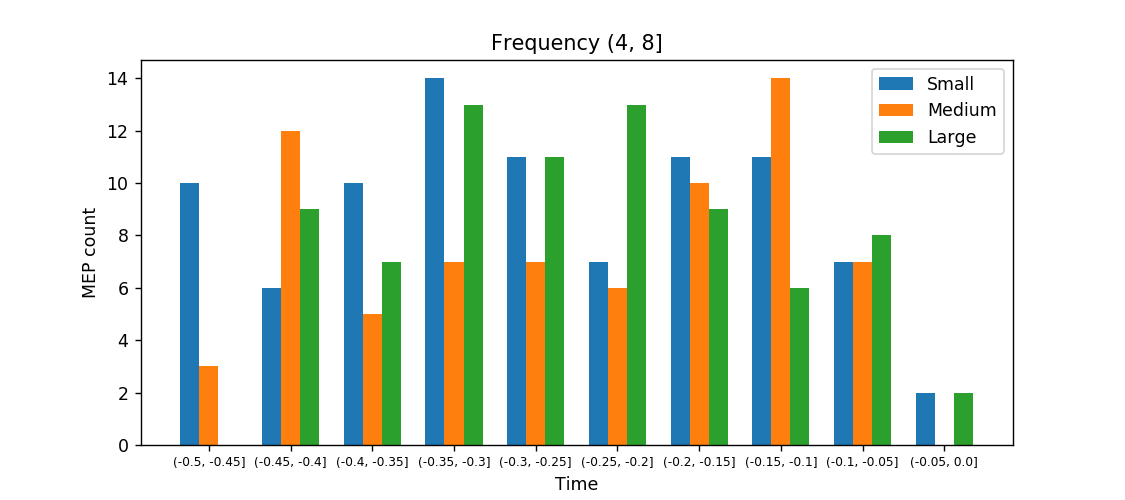

<IPython.core.display.Javascript object>


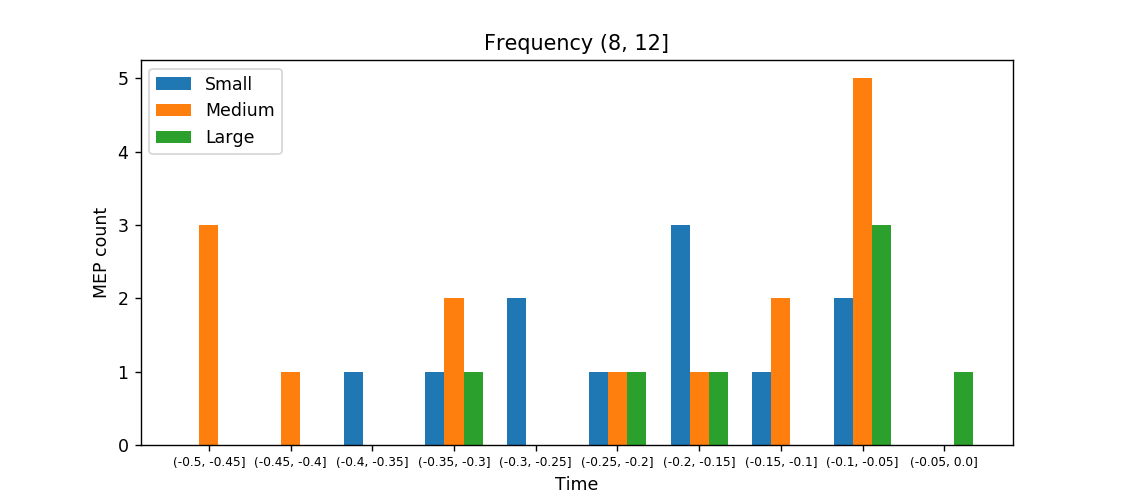

<IPython.core.display.Javascript object>


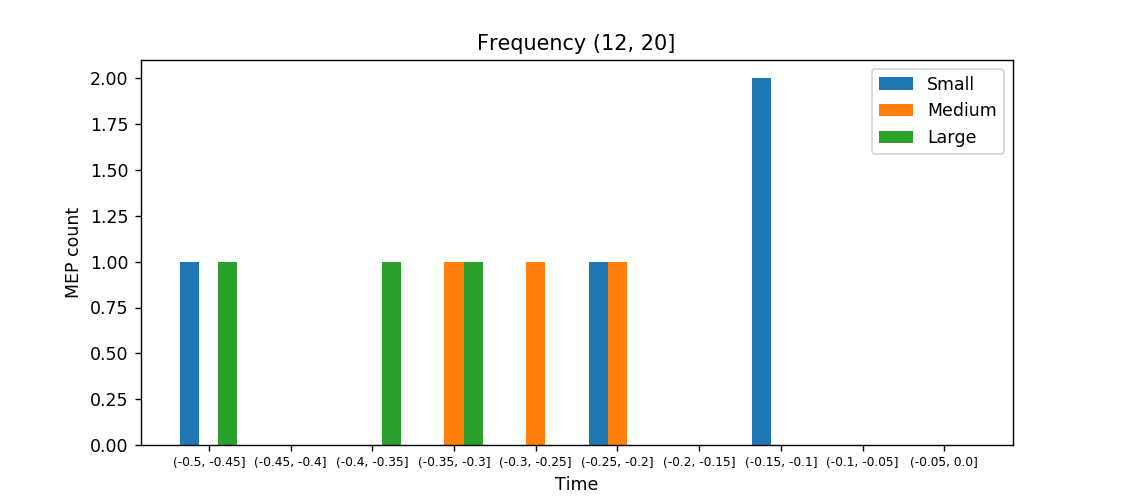

In [156]:
def plot_mep_bar_chart_across_time(freq_range='(0, 4]'):
    df_small = df_percentile_small[df_percentile_small['wavelet_ltm1_max_power_at_freq_bin'].astype(str) == freq_range]
    ind = np.arange(df_small.shape[0])
    width = 0.35
    fig, ax = plt.subplots(figsize=(9,4))
    ax.bar(ind * 1.5, df_small['ltm1_all_max_amplitude'], width, label='Small')

    df_medium = df_percentile_medium[df_percentile_medium['wavelet_ltm1_max_power_at_freq_bin'].astype(str) == freq_range]
    ax.bar(ind * 1.5 + width, df_medium['ltm1_all_max_amplitude'], width, label='Medium')

    df_large = df_percentile_large[df_percentile_large['wavelet_ltm1_max_power_at_freq_bin'].astype(str) == freq_range]
    ax.bar(ind * 1.5 + 2*width, df_large['ltm1_all_max_amplitude'], width, label='Large')

    ax.set_xlabel('Time')
    ax.set_ylabel('MEP count')
    ax.set_title('Frequency ' + freq_range)
    ax.set_xticks(ind * 1.5 + width)
    ax.set_xticklabels(df_small['wavelet_ltm1_max_power_at_time_bin'], fontdict={'fontsize':7})
    ax.legend()

plot_mep_bar_chart_across_time('(0, 4]')
plot_mep_bar_chart_across_time('(4, 8]')
plot_mep_bar_chart_across_time('(8, 12]')
plot_mep_bar_chart_across_time('(12, 20]')

In [157]:
print(df2['wavelet_all_max_power_freq'].min())
print(df2['wavelet_all_max_power_freq'].max())

print(df2['wavelet_ltm1_max_power_freq'].min())
print(df2['wavelet_ltm1_max_power_freq'].max())

print(df2['wavelet_rtm1_max_power_freq'].min())
print(df2['wavelet_rtm1_max_power_freq'].max())

3.726550481103787e-14
2.535198074977731e-11
49.1217305019297
38468.4826329094
74.86983796843246
971047.2892801213


In [162]:
def categorize_by_freq_power(df2, bins=[0, 4, 8, 12, 20, 30, 46, 70]):
    df2['wavelet_all_max_power_at_freq_bin'] = pd.cut(df2['wavelet_all_max_power_at_freq'], bins)
    df2['wavelet_all_max_power_freq_bin'] = pd.cut(df2['wavelet_all_max_power_freq'], np.linspace(1*10e-14, 3*10e-11, 11))
    
    df2['wavelet_ltm1_max_power_at_freq_bin'] = pd.cut(df2['wavelet_ltm1_max_power_at_freq'], bins)
    # np.linspace(0, 40000, 11)
    df2['wavelet_ltm1_max_power_freq_bin'] = pd.cut(df2['wavelet_ltm1_max_power_freq'], [0, 1000, 2000, 3000, 4000, 6000, 8000, 12000, 20000, 40000])
    
    df2['wavelet_rtm1_max_power_at_freq_bin'] = pd.cut(df2['wavelet_rtm1_max_power_at_freq'], bins)
    df2['wavelet_rtm1_max_power_freq_bin'] = pd.cut(df2['wavelet_rtm1_max_power_freq'], np.linspace(0, 980000, 11))
    return df2

def groupby_freq_power(df):
    df = pd.DataFrame(df.to_records())
    df['wavelet_ltm1_max_power_at_freq_bin_left'] = df['wavelet_ltm1_max_power_at_freq_bin'].apply(lambda x: x.left)
    df['wavelet_ltm1_max_power_freq_bin_left'] = df['wavelet_ltm1_max_power_freq_bin'].apply(lambda x: x.left)
    df = df.fillna(0)
    return df

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

<IPython.core.display.Javascript object>


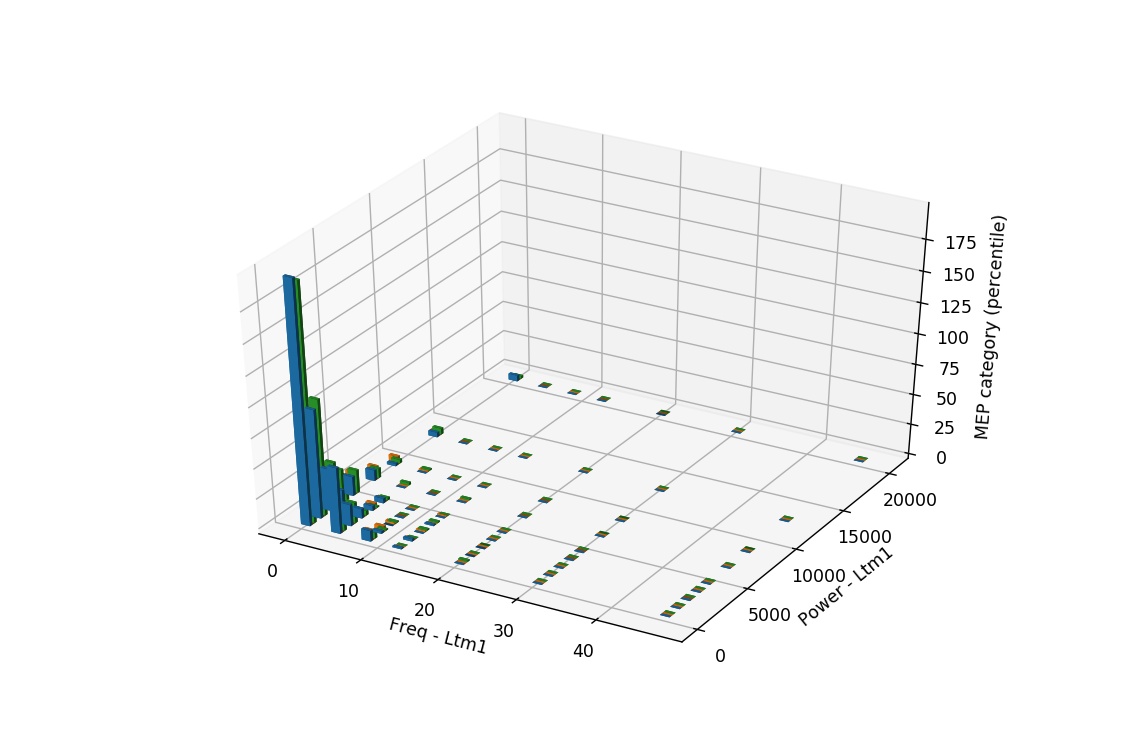

In [164]:
df_percentile_small = categorize_by_freq_power(df2[df2['mep_category_percentile'] == 0]).groupby(['wavelet_ltm1_max_power_at_freq_bin', 'wavelet_ltm1_max_power_freq_bin']).count()
df_percentile_small = groupby_freq_power(df_percentile_small)

df_percentile_medium = categorize_by_freq_power(df2[df2['mep_category_percentile'] == 1]).groupby(['wavelet_ltm1_max_power_at_freq_bin', 'wavelet_ltm1_max_power_freq_bin']).count()
df_percentile_medium = groupby_freq_power(df_percentile_medium)

df_percentile_large = categorize_by_freq_power(df2[df2['mep_category_percentile'] == 2]).groupby(['wavelet_ltm1_max_power_at_freq_bin', 'wavelet_ltm1_max_power_freq_bin']).count()
df_percentile_large = groupby_freq_power(df_percentile_large)

power_width = 200
freq_width = 1.2
fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection='3d')
ax.bar3d(df_percentile_small['wavelet_ltm1_max_power_at_freq_bin_left'], df_percentile_small['wavelet_ltm1_max_power_freq_bin_left'], np.zeros_like(df_percentile_small['ltm1_all_max_amplitude']), freq_width, power_width, df_percentile_small['ltm1_all_max_amplitude'], shade=True, zorder=0.5)
ax.bar3d(df_percentile_medium['wavelet_ltm1_max_power_at_freq_bin_left'], df_percentile_medium['wavelet_ltm1_max_power_freq_bin_left'] + power_width, np.zeros_like(df_percentile_medium['ltm1_all_max_amplitude']), freq_width, power_width, df_percentile_medium['ltm1_all_max_amplitude'], shade=True, zorder=0.4)
ax.bar3d(df_percentile_large['wavelet_ltm1_max_power_at_freq_bin_left'], df_percentile_large['wavelet_ltm1_max_power_freq_bin_left'] + power_width * 2, np.zeros_like(df_percentile_large['ltm1_all_max_amplitude']), freq_width, power_width, df_percentile_large['ltm1_all_max_amplitude'], shade=True, zorder=0.3)
ax.set_xlabel('Freq - Ltm1')
ax.set_ylabel('Power - Ltm1')
ax.set_zlabel('MEP category (percentile)');

<IPython.core.display.Javascript object>


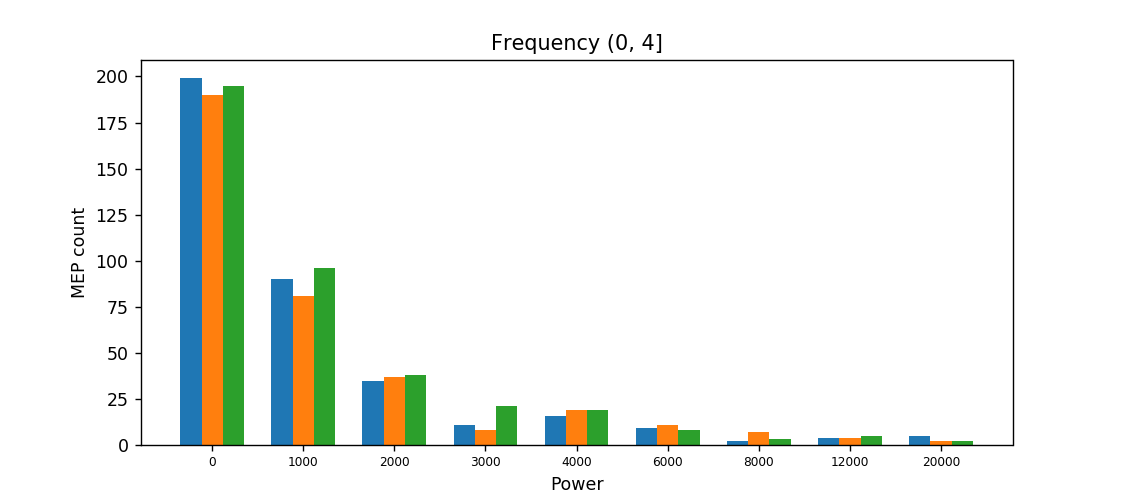

<IPython.core.display.Javascript object>


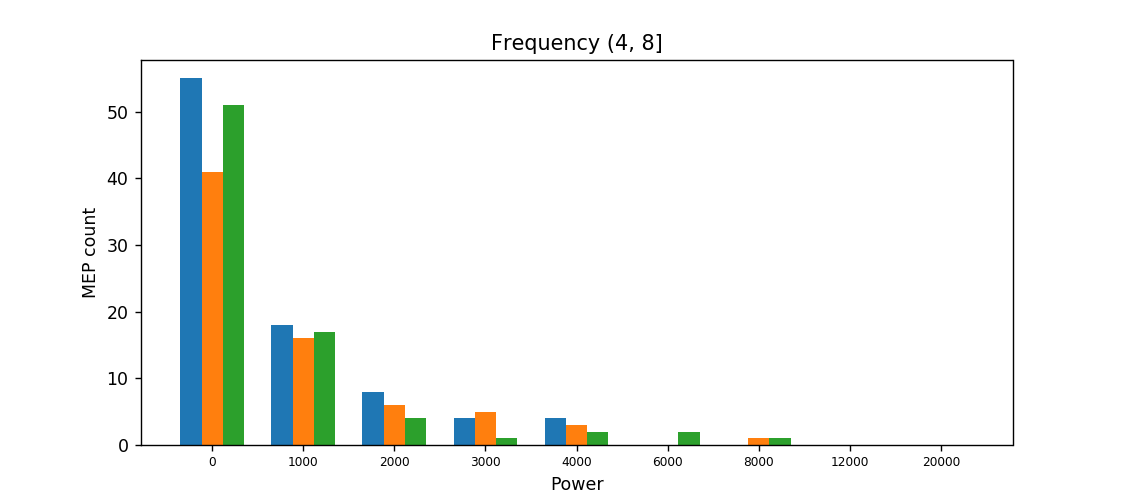

<IPython.core.display.Javascript object>


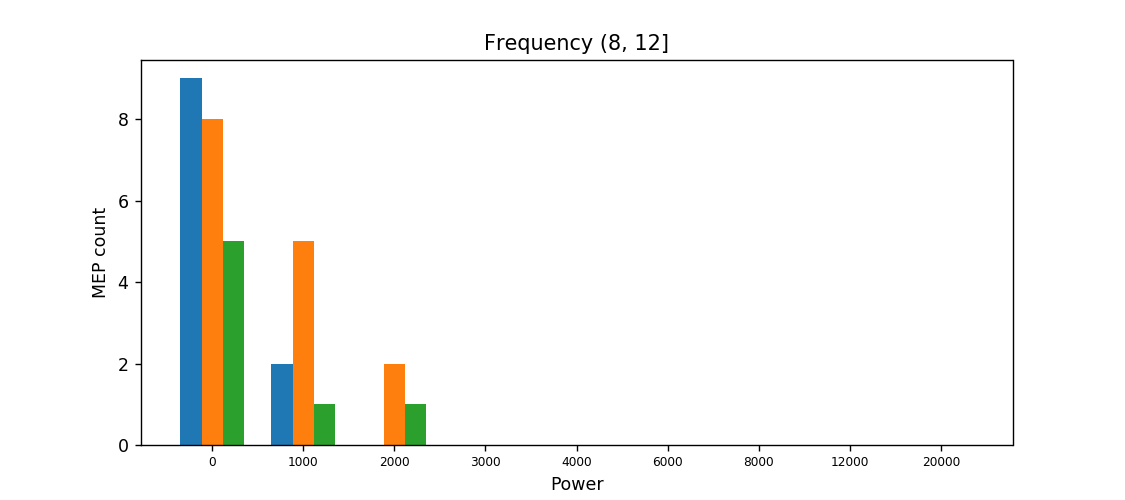

<IPython.core.display.Javascript object>


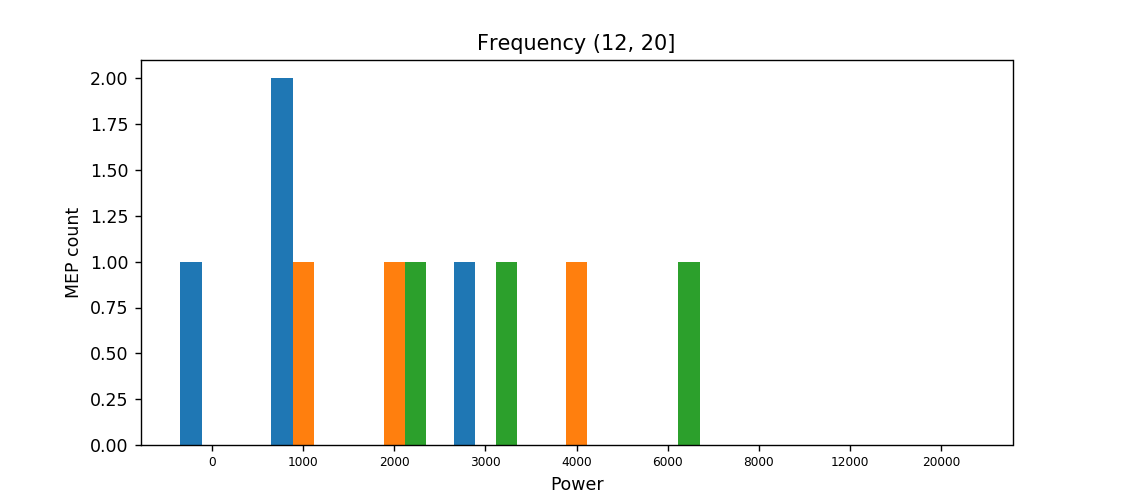

In [165]:
def plot_mep_bar_chart_across_power(freq_range='(0, 4]'):
    df_small = df_percentile_small[df_percentile_small['wavelet_ltm1_max_power_at_freq_bin'].astype(str) == freq_range]
    ind = np.arange(df_small.shape[0])
    width = 0.35
    fig, ax = plt.subplots(figsize=(9,4))
    ax.bar(ind * 1.5, df_small['ltm1_all_max_amplitude'], width, label='Small')

    df_medium = df_percentile_medium[df_percentile_medium['wavelet_ltm1_max_power_at_freq_bin'].astype(str) == freq_range]
    ax.bar(ind * 1.5 + width, df_medium['ltm1_all_max_amplitude'], width, label='Medium')

    df_large = df_percentile_large[df_percentile_large['wavelet_ltm1_max_power_at_freq_bin'].astype(str) == freq_range]
    ax.bar(ind * 1.5 + 2*width, df_large['ltm1_all_max_amplitude'], width, label='Large')

    ax.set_xlabel('Power')
    ax.set_ylabel('MEP count')
    ax.set_title('Frequency ' + freq_range)
    ax.set_xticks(ind * 1.5 + width)
    ax.set_xticklabels(df_small['wavelet_ltm1_max_power_freq_bin_left'], fontdict={'fontsize':7})
    
plot_mep_bar_chart_across_power('(0, 4]')
plot_mep_bar_chart_across_power('(4, 8]')
plot_mep_bar_chart_across_power('(8, 12]')
plot_mep_bar_chart_across_power('(12, 20]')

# Plot Frequency vs MEP Area

In [ ]:
plt.figure(figsize=(14,4))
plt.plot(df['ltm1_all_max_power_freq'], df['mep_area'], '.')
plt.xlabel('Frequency (Hz)')
plt.ylabel('MEP Area')

plt.figure(figsize=(14,4))
plt.plot(df['ltm1_alpha_max_power_freq'], df['mep_area'], '.')
plt.xlabel('Frequency - alpha band (Hz)')
plt.ylabel('MEP Area')

plt.figure(figsize=(14,4))
plt.plot(df['ltm1_beta_max_power_freq'], df['mep_area'], '.')
plt.xlabel('Frequency - beta band (Hz)')
plt.ylabel('MEP Area')

plt.figure(figsize=(14,4))
plt.plot(df['ltm1_gamma_max_power_freq'], df['mep_area'], '.')
plt.xlabel('Frequency - gamma band (Hz)')
plt.ylabel('MEP Area')

plt.figure(figsize=(14,4))
plt.plot(df['ltm1_delta_max_power_freq'], df['mep_area'], '.')
plt.xlabel('Frequency - delta band (Hz)')
plt.ylabel('MEP Area')

plt.figure(figsize=(14,4))
plt.plot(df['ltm1_theta_max_power_freq'], df['mep_area'], '.')
plt.xlabel('Frequency - theta band (Hz)')
plt.ylabel('MEP Area')

In [ ]:
df2 = df.groupby(['sub', 'exp', 'run']).mean()
df2.head()

In [ ]:
df2.shape

In [ ]:
plt.figure(figsize=(14,4))
plt.plot(df2['ltm1_all_max_power_freq'], df2['mep_size'], 'o')
plt.xlabel('LtM1 Frequency (Hz)')
plt.ylabel('MEP Size')

In [ ]:
plt.figure(figsize=(14,4))
plt.plot(df2['ltm1_alpha_max_power_freq'], df2['mep_size'], 'o')
plt.xlabel('LtM1 Frequency - alpha band (Hz)')
plt.ylabel('MEP Size')

# Frequency bins

In [ ]:
bins = [0, 4, 8, 12, 20, 30, 46, 70]
df3_mean = df.groupby(pd.cut(df['rtm1_all_max_power_freq'], bins)).mean()
df3_max = df.groupby(pd.cut(df['rtm1_all_max_power_freq'], bins)).max()
df3_min = df.groupby(pd.cut(df['rtm1_all_max_power_freq'], bins)).min()
df3_mean['mep_size_mean'] = df3_mean['mep_size']
df3_mean['mep_size_max'] = df3_max['mep_size']
df3_mean['mep_size_min'] = df3_min['mep_size']
df3_mean['rtm1_all_max_power_freq'] = df3_mean.index

In [ ]:
df3_mean[['rtm1_all_max_power_freq', 'mep_size_mean', 'mep_size_max', 'mep_size_min']]

In [ ]:
df4 = df
bins = [0, 4, 8, 12, 20, 30, 46, 70]
df4['bin'] = pd.cut(df4['ltm1_all_max_power_freq'], bins)
df4.head()

fig = plt.figure(figsize=(14, 8))
ax = sns.boxplot(x="bin", y="mep_size", data=df4)
ax.set_xlabel('Frequency Bin')
ax.set_ylabel('MEP Size')
ax.set_title('Left M1 Electrode Frequency Bins vs MEP Size')

df4 = df
df4['bin'] = pd.cut(df4['rtm1_all_max_power_freq'], bins)
df4.head()

fig = plt.figure(figsize=(14, 8))
ax = sns.boxplot(x="bin", y="mep_size", data=df4)
ax.set_xlabel('Frequency Bin')
ax.set_ylabel('MEP Size')
ax.set_title('Right M1 Electrode Frequency Bins vs MEP Size')

df4 = df
df4['bin'] = pd.cut(df4['all_all_max_power_freq'], bins)
df4.head()

fig = plt.figure(figsize=(14, 8))
ax = sns.boxplot(x="bin", y="mep_size", data=df4)
ax.set_xlabel('Frequency Bin')
ax.set_ylabel('MEP Size')
ax.set_title('All Electrodes Frequency Bins vs MEP Size')

df4 = df
df4['bin'] = pd.cut(df4['central_all_max_power_freq'], bins)
df4.head()

fig = plt.figure(figsize=(14, 8))
ax = sns.boxplot(x="bin", y="mep_size", data=df4)
ax.set_xlabel('Frequency Bin')
ax.set_ylabel('MEP Size')
ax.set_title('Central Electrodes Frequency Bins vs MEP Size')

# 3D Plot

In [ ]:
# df2 = df
# df3 = []
# for row in df2:
#     row['']
#     df3.append()

df4 = df
bins = [0, 4, 8, 12, 20, 30, 46, 70]
df4['bin'] = pd.cut(df4['ltm1_all_max_power_freq'], bins)
df4.head()

# MEP size group chart

In [ ]:
df5 = df4.groupby(['bin_str', 'mep_category']).count()
df5 = df5[['mep_area']]
df5 = df5.unstack()
df5.columns = ['small', 'medium', 'large']
df5 = df5.sort_index(axis=0)
df5['order'] = [0, 3, 4, 5, 1, 2]
df5 = df5.sort_values(by=['order'])
df5 = df5.drop('order', axis=1)
df5

In [ ]:
ax = df5.plot(kind='bar', figsize=(12,4), colormap='Accent')
ax.set_xlabel('Frequency')
ax.set_ylabel('Count')

plt.figure(figsize=(12,4))
plt.plot(df5.index, df5['small'], color='r', label='small')
plt.plot(df5.index, df5['medium'], color='k', label='medium')
plt.plot(df5.index, df5['large'], color='c', label='large')
plt.xlabel('Frequency')
plt.ylabel('Count')
plt.legend()

# EEG area and amplitude

In [ ]:
plt.plot(df4['area_under_eeg'], df4['mep_size'], 'o')
plt.xlabel('Area under EEG - all electrodes')
plt.ylabel('MEP Size')

In [ ]:
plt.plot(df4['rtm1_area_under_eeg'], df4['mep_size'], 'o')
plt.xlabel('Area under EEG - right M1 electrodes')
plt.ylabel('MEP Size')

In [ ]:
plt.plot(df4['ltm1_area_under_eeg'], df4['mep_size'], 'o')
plt.xlabel('Area under EEG - left M1 electrodes')
plt.ylabel('MEP Size')

In [ ]:
plt.plot(df4['all_max_amplitude'], df4['mep_size'], 'o')
plt.xlabel('Max amplitude - all electrodes')
plt.ylabel('MEP Size')

In [ ]:
plt.plot(df4['ltm1_max_amplitude'], df4['mep_size'], 'o')
plt.xlabel('Max amplitude - Left M1 electrodes')
plt.ylabel('MEP Size')

In [ ]:
plt.plot(df4['rtm1_max_amplitude'], df4['mep_size'], 'o')
plt.xlabel('Max amplitude - Right M1 electrodes')
plt.ylabel('MEP Size')

# Linear Regression

In [ ]:
df.dtypes

In [ ]:
x = df[['all_all_max_power', 
        'all_all_max_power_freq', 'all_alpha_max_power',
        'all_alpha_max_power_freq', 'all_beta_max_power',
        'all_beta_max_power_freq', 'all_delta_max_power',
        'all_delta_max_power_freq', 'all_gamma_max_power',
        'all_gamma_max_power_freq', 'all_max_amplitude', 'all_theta_max_power',
        'all_theta_max_power_freq', 'area_under_eeg',
        
        'ltm1_all_max_power', 
        'ltm1_all_max_power_freq', 'ltm1_alpha_max_power',
        'ltm1_alpha_max_power_freq', 'ltm1_area_under_eeg',
        'ltm1_beta_max_power', 'ltm1_beta_max_power_freq',
        'ltm1_delta_max_power', 'ltm1_delta_max_power_freq',
        'ltm1_gamma_max_power', 'ltm1_gamma_max_power_freq',
        'ltm1_max_amplitude', 'ltm1_theta_max_power',
        'ltm1_theta_max_power_freq', 
        
        'rtm1_all_max_power',
        'rtm1_all_max_power_freq', 'rtm1_alpha_max_power',
        'rtm1_alpha_max_power_freq', 'rtm1_area_under_eeg',
        'rtm1_beta_max_power', 'rtm1_beta_max_power_freq',
        'rtm1_delta_max_power', 'rtm1_delta_max_power_freq',
        'rtm1_gamma_max_power', 'rtm1_gamma_max_power_freq',
        'rtm1_max_amplitude', 'rtm1_theta_max_power',
        'rtm1_theta_max_power_freq',

        'central_all_max_power',
        'central_all_max_power_freq', 'central_alpha_max_power',
        'central_alpha_max_power_freq', 'central_area_under_eeg',
        'central_beta_max_power', 'central_beta_max_power_freq',
        'central_delta_max_power', 'central_delta_max_power_freq',
        'central_gamma_max_power', 'central_gamma_max_power_freq',
        'central_max_amplitude', 'central_theta_max_power',
        'central_theta_max_power_freq']]
y = df['mep_size']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=23)

In [ ]:
model = LinearRegression().fit(x_train, y_train)

In [ ]:
y_predicted = model.predict(x_test)
rmse = mean_squared_error(y_test, y_predicted)
r2 = r2_score(y_test, y_predicted)
print(r2)

In [ ]:
plt.plot(y_test, y_predicted, 'o')

# Random Forest

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.feature_selection import SelectPercentile, f_regression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator

In [ ]:
rf = RandomForestRegressor(n_estimators = 5000, random_state = 42)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
print("R2 score:", sklearn.metrics.r2_score(y_test, y_pred))

In [ ]:
plt.plot(y_test, y_pred, 'o')

# SVR

In [ ]:
from sklearn.svm import SVR

In [ ]:
clf = SVR()
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print("R2 score:", sklearn.metrics.r2_score(y_test, y_pred))
plt.plot(y_test, y_pred, 'o')

# TPOT

In [ ]:
tpot = TPOTRegressor(n_jobs=-1, verbosity=2)
tpot.fit(x_train, y_train)
print(tpot.score(x_test, y_test))
predictions = tpot.predict(x_test)
print("R2 score:", sklearn.metrics.r2_score(y_test, predictions))
tpot.export('tpot_01_pipeline_accuracy_100.py')

In [ ]:
tpot = TPOTRegressor(n_jobs=-1, verbosity=2, scoring='r2')
tpot.fit(x_train, y_train)
print(tpot.score(x_test, y_test))
predictions = tpot.predict(x_test)
print("R2 score:", sklearn.metrics.r2_score(y_test, predictions))
tpot.export('tpot_02_pipeline_r2_100.py')

In [ ]:
tpot = TPOTRegressor(n_jobs=-1, verbosity=2, generations=400, population_size=400, scoring='r2')
tpot.fit(x_train, y_train)
print(tpot.score(x_test, y_test))
predictions = tpot.predict(x_test)
print("R2 score:", sklearn.metrics.r2_score(y_test, predictions))
tpot.export('tpot_03_pipeline_r2_400.py')

In [ ]:
tpot = TPOTRegressor(n_jobs=-1, verbosity=2, generations=400, population_size=400)
tpot.fit(x_train, y_train)
print(tpot.score(x_test, y_test))
predictions = tpot.predict(x_test)
print("R2 score:", sklearn.metrics.r2_score(y_test, predictions))
tpot.export('tpot_03_pipeline_accuracy_400.py')

# Test pipeline

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.feature_selection import SelectPercentile, f_regression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator

In [ ]:
exported_pipeline = make_pipeline(
    SelectPercentile(score_func=f_regression, percentile=7),
    StackingEstimator(estimator=KNeighborsRegressor(n_neighbors=29, p=1, weights="distance")),
    StackingEstimator(estimator=ExtraTreesRegressor(bootstrap=False, max_features=0.25, min_samples_leaf=20, min_samples_split=15, n_estimators=100)),
    SelectPercentile(score_func=f_regression, percentile=48),
    RandomForestRegressor(bootstrap=False, max_features=0.6000000000000001, min_samples_leaf=14, min_samples_split=16, n_estimators=100)
)

exported_pipeline.fit(x_train, y_train)
print("Train R2 score:", sklearn.metrics.r2_score(y_train, exported_pipeline.predict(x_train)))
print("Test R2 score:", sklearn.metrics.r2_score(y_test, exported_pipeline.predict(x_test)))